<a href="https://colab.research.google.com/github/mgalao/deep-learning-project/blob/main/project/DL_Models_from_scratch_carolina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [2]:
from google.colab import drive

In [3]:
drive.flush_and_unmount()

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# Change to the directory where project is located
os.chdir('/content/drive/MyDrive/FACULDADE/mestrado/')

# # Verify that we changed the directory
print("Changed directory to:", os.getcwd())

Changed directory to: /content/drive/MyDrive/FACULDADE/mestrado


## 1.2 Import Libraries

In [6]:
pip install keras_cv

In [7]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping


from classes import *
from functions import *

In [8]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, Concatenate, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import pandas as pd
from IPython.display import display
import tensorflow.keras.backend as K
import gc
from tensorflow.keras.layers import ReLU


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1.3 Import Dataset

In [9]:
# #Load the DataFrames from the .pkl files
# with open("../data/train_df.pkl", "rb") as f:
#      train_df = pickle.load(f)

# with open("../data/val_df.pkl", "rb") as f:
#      val_df = pickle.load(f)

# with open("../data/test_df.pkl", "rb") as f:
#      test_df = pickle.load(f)

# with open("../data/train_df_sampled.pkl", "rb") as f:
#      train_df_sampled = pickle.load(f)

# with open("../data/family_encoder.pkl", "rb") as f:
#      family_encoder = pickle.load(f)

In [10]:
# FOR COLLAB
# Load the DataFrames from the .pkl files
with open("data/train_df.pkl", "rb") as f:
     train_df = pickle.load(f)

with open("data/val_df.pkl", "rb") as f:
     val_df = pickle.load(f)

with open("data/test_df.pkl", "rb") as f:
     test_df = pickle.load(f)

with open("data/train_df_sampled.pkl", "rb") as f:
     train_df_sampled = pickle.load(f)

with open("data/family_encoder.pkl", "rb") as f:
     family_encoder = pickle.load(f)

<div class="alert alert-block alert-success">

# **2.** Preprocessing

<div>

- Normalizes pixel values (e.g., rescaling from [0,255] to [0,1]).
- Resizes images to a fixed size (e.g., 224x224 pixels).
- Applies augmentation (only during training).
- Converts images to batches (e.g., batch_size=32 loads 32 images at a time).

In [11]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [29]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment='mixup', oversampling=True, shuffle=True)
train_ds_sampled, class_names = preprocess.load_img(data_dir="data/rare_species/train_sampled", minority_class=minority_class, augment='medium', oversampling=True, shuffle=True)
val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
test_ds, _ = preprocess.load_img(data_dir="data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

Found 8388 files belonging to 202 classes.
Found 4194 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Found 749 files belonging to 202 classes.


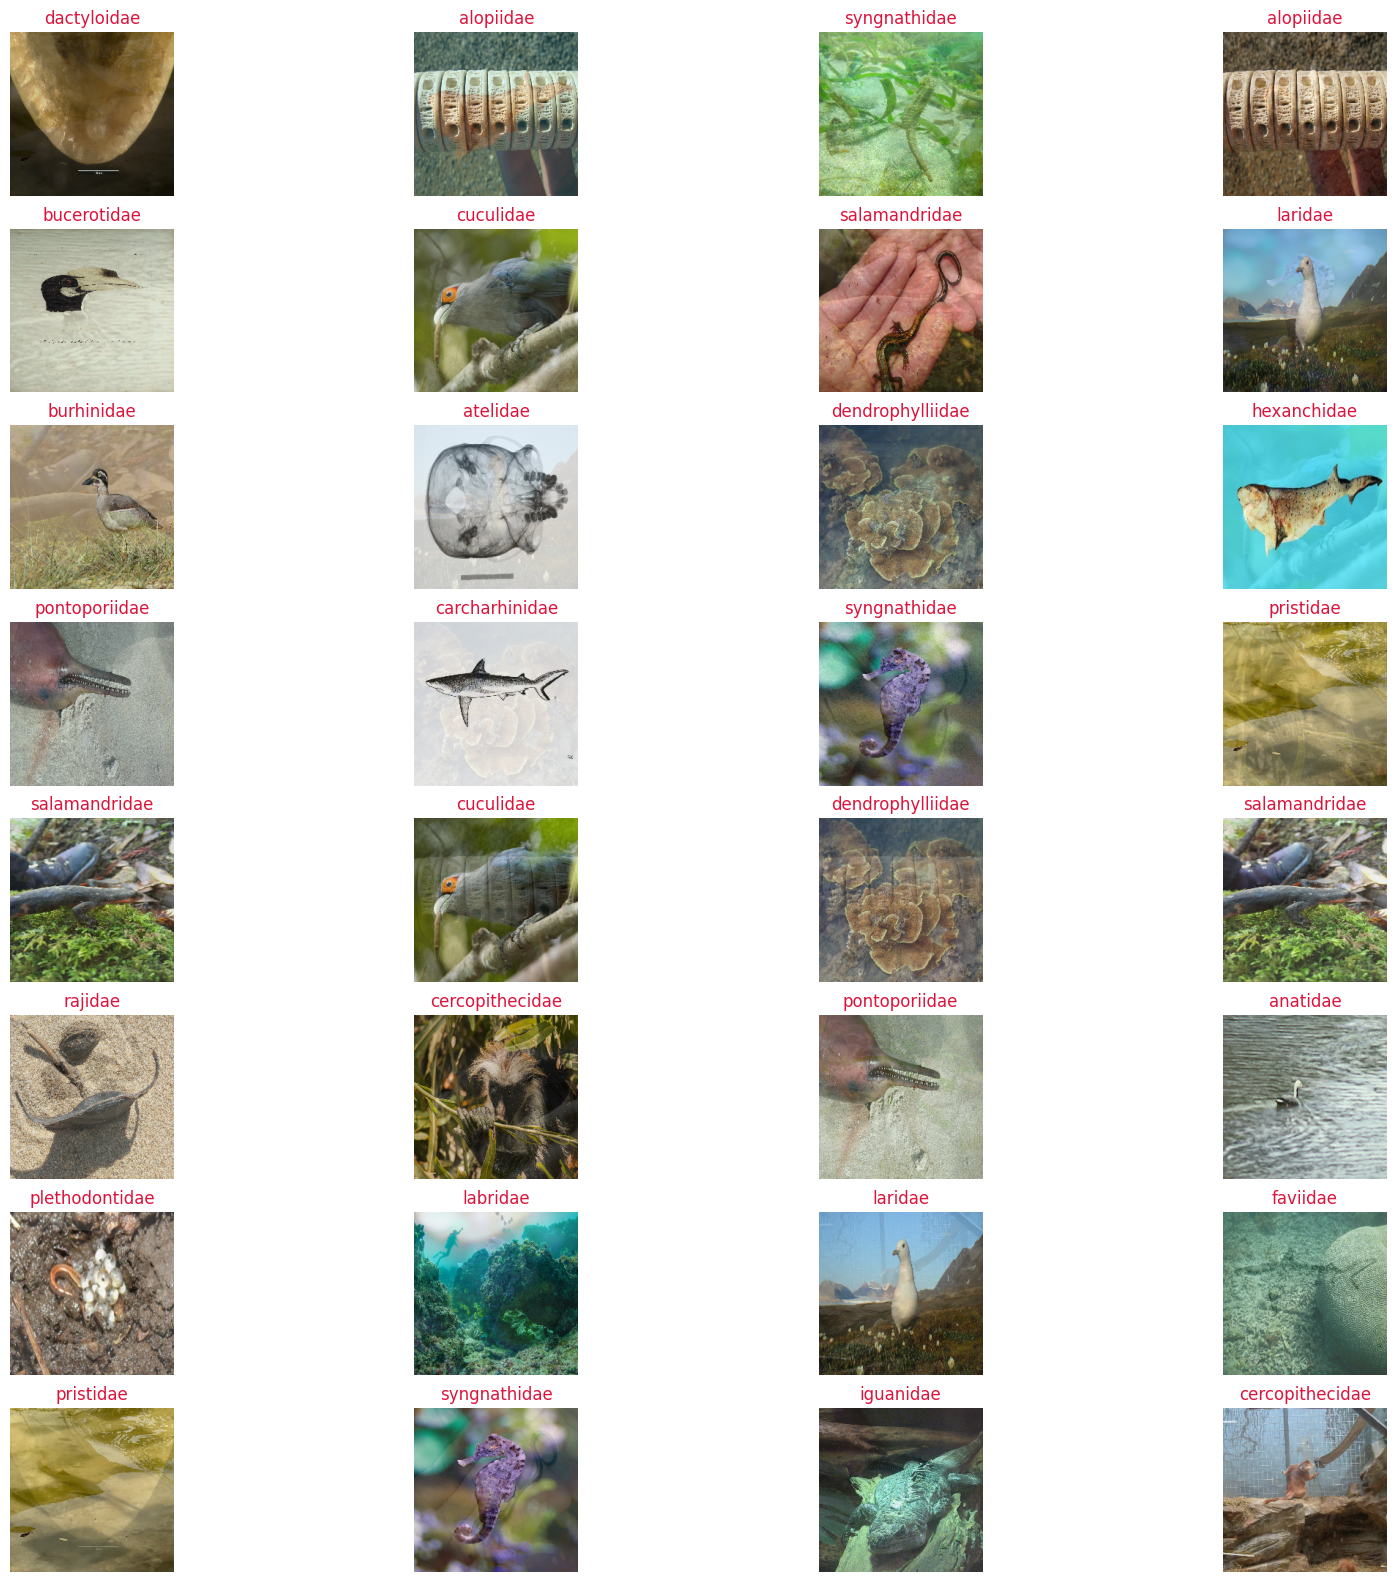

In [30]:
num_images = 32 ##
rows, cols = 8, 4 ##

plot_batch(train_ds, class_names=class_names, num_images=num_images, rows=rows, cols=cols)

## (augmentations)

In [14]:
# augmentations_to_test = [
#     # "none",
#     # "light",
#     # "medium",
#     # "heavy",
#     # "grayscale",
#     # "randaugment",
#     "mixup",
#     "cutmix"]

<!-- ##### Simple model do test augmentations -->

In [15]:
# def build_model(num_classes):
#     base = keras.applications.EfficientNetB0(
#         input_shape=(224, 224, 3),
#         include_top=False,
#         weights="imagenet",
#         pooling="avg"
#     )
#     base.trainable = False  # You can fine-tune later

#     inputs = keras.Input(shape=(224, 224, 3))
#     x = base(inputs, training=False)
#     x = keras.layers.Dropout(0.2)(x)
#     outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

#     return keras.Model(inputs, outputs)

In [16]:
# def sample_dataset(dataset, fraction=None, num_batches=None, seed=42):
#     """Return a sampled subset of the dataset."""
#     if fraction:
#         dataset = dataset.shuffle(1000, seed=seed)
#         dataset = dataset.take(int(fraction * tf.data.experimental.cardinality(dataset).numpy()))
#     elif num_batches:
#         dataset = dataset.take(num_batches)
#     return dataset

<!-- ##### Loop -->

In [17]:
# # Initialize the preprocessor
# pre = Preprocessor(image_size=(224, 224), batch_size=32)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     # Load datasets
#     train_ds, class_names = pre.load_img(
#         data_dir="../data/rare_species/train",
#         augment=aug
#     )

#     val_ds, _ = pre.load_img(
#         data_dir="../data/rare_species/val",
#         augment=None
#     )

#     # Sample a subset of training data
#     train_ds = sample_dataset(train_ds, fraction=0.5)

#     # Build a fresh model (you should define this function)
#     model = build_sequential_model(list_of_layers=layers)

#     # Compile
#     model.compile(
#         optimizer="adam",
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )

#     # Train
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=5,
#         verbose=1
#     )

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "val_accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")


In [18]:
# augmentations_to_test = [
#     "none",
#     "light",
#     "medium",
#     "heavy",
#     "grayscale",
#     "randaugment",
#     "mixup",
#     "cutmix"]

In [19]:
# # Initialize the preprocessor
# pre = Preprocessor(image_size=(224, 224), batch_size=32)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     # Load datasets
#     train_ds, class_names = pre.load_img(
#         data_dir="../data/rare_species/train",
#         augment=aug
#     )

#     val_ds, _ = pre.load_img(
#         data_dir="../data/rare_species/val",
#         augment=None
#     )

#     # Sample a subset of training data
#     train_ds = sample_dataset(train_ds, fraction=0.5)

#     # Build a fresh model (you should define this function)
#     model = build_sequential_model(list_of_layers=layers)

#     # Compile
#     model.compile(
#         optimizer="adam",
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )

#     # Train
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=15,
#         verbose=1
#     )

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "val_accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")


<div class="alert alert-block alert-success">

# **3.** Parameters

<div>

In [20]:
# Add callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    ,EarlyStopping(patience=7, restore_best_weights=True, monitor="val_loss", verbose=1)
]

In [21]:
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_macro"),
    F1Score(average="weighted", name="f1_weighted"),
    TopKCategoricalAccuracy(k=5, name="top5_accuracy")
]

In [22]:
augmentations_to_test = [
    "none",
    "light",
    "mixup",
    "medium",
    "heavy",
    "grayscale_plus",
    "randaugment",
    ]

<div class="alert alert-block alert-success">

# **4.** Models

<div>

## 4.2 AlexNet - No oversampling


In [22]:
def build_alexnet(input_shape=(224, 224, 3), num_classes=202):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Layer 2
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Layer 3
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 4
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 5
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Flatten and FC
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_alexnet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=metrics
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 202)            │       827,594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,576,010 (181.49 MB)

 Trainable params: 47,575,306 (181.49 MB)

 Non-trainable params: 704 (2.75 KB)

In [23]:
# Initialize the preprocessor
batch_size = 32
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store results
results = {}

# Loop through each augmentation
for aug in augmentations_to_test:
    print(f"\nTraining with augmentation: {aug}")

    model = build_alexnet()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics
    )

    train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=False, shuffle=True)
    if aug=="grayscale_plus":
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment='grayscale', oversampling=False)
    else:
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)

    # Initialize the experiment
    experiment = Experiment(
        model=model,
        train_ds=train_ds,
        val_ds=val_ds,
        experiment_name=f"alexnet_with_{aug}_no_oversampling", # MUDAR NOME!!!!!!!!!!!!
        batch_size=32,
        image_size=(224, 224),
        save_model = False
    )

    # Run the experiment
    history = experiment.run_experiment(callbacks=callbacks, epochs=30)

    # Predict entire validation set at once
    preds = model.predict(val_ds)
    y_pred = np.argmax(preds, axis=1)

    # Extract true labels in order
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

    # Compute metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store in results
    train_eval = model.evaluate(train_ds, verbose=0)
    val_eval = model.evaluate(val_ds, verbose=0)

    metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

    train_metrics = dict(zip(metric_names, train_eval))
    val_metrics = dict(zip(metric_names, val_eval))

    # Results
    results[aug] = {
        "train_loss": train_metrics["loss"],
        "val_loss": val_metrics["loss"],

        "train_accuracy": train_metrics["accuracy"],
        "val_accuracy": val_metrics["accuracy"],

        "train_f1_macro": train_metrics.get("f1_macro"),
        "val_f1_macro": val_metrics.get("f1_macro"),

        "val_f1_weighted": val_metrics.get("f1_weighted")
    }


Training with augmentation: none
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 66s 207ms/step - accuracy: 0.0243 - auc: 0.6244 - f1_macro: 0.0018 - f1_weighted: 0.0053 - loss: 5.5546 - top5_accuracy: 0.1011 - val_accuracy: 0.0239 - val_auc: 0.6652 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0437 - val_top5_accuracy: 0.1135 - learning_rate: 0.0010
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.0243 - auc: 0.6614 - f1_macro: 0.0011 - f1_weighted: 0.0049 - loss: 5.0596 - top5_accuracy: 0.1174 - val_accuracy: 0.0239 - val_auc: 0.6643 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0425 - val_top5_accuracy: 0.1157 - learning_rate: 0.0010
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.0236 - auc: 0.6608 - f1_macro: 8.8843e-04 - f1_weighted: 0.0043 - loss: 5.0590 - top5_accuracy: 0.1120 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: light


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 85s 281ms/step - accuracy: 0.0220 - auc: 0.6440 - f1_macro: 0.0011 - f1_weighted: 0.0048 - loss: 6.0177 - top5_accuracy: 0.1053 - val_accuracy: 0.0239 - val_auc: 0.6637 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0414 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.0250 - auc: 0.6638 - f1_macro: 6.3757e-04 - f1_weighted: 0.0032 - loss: 5.0527 - top5_accuracy: 0.1135 - val_accuracy: 0.0239 - val_auc: 0.6656 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0395 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.0243 - auc: 0.6627 - f1_macro: 8.0741e-04 - f1_weighted: 0.0040 - loss: 5.0491 - top5_accuracy: 0.1187 - val_accuracy: 0.0223 - val_a

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: mixup


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 56s 180ms/step - accuracy: 0.0242 - auc: 0.6444 - f1_macro: 0.0015 - f1_weighted: 0.0051 - loss: 5.7208 - top5_accuracy: 0.1060 - val_accuracy: 0.0239 - val_auc: 0.6579 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0467 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.0249 - auc: 0.6600 - f1_macro: 9.9389e-04 - f1_weighted: 0.0046 - loss: 5.0682 - top5_accuracy: 0.1117 - val_accuracy: 0.0239 - val_auc: 0.6579 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0495 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.0231 - auc: 0.6583 - f1_macro: 8.5052e-04 - f1_weighted: 0.0040 - loss: 5.0667 - top5_accuracy: 0.1113 - val_accuracy: 0.0239 - val_a

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: medium


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 295ms/step - accuracy: 0.0260 - auc: 0.6462 - f1_macro: 0.0013 - f1_weighted: 0.0060 - loss: 5.4774 - top5_accuracy: 0.1146 - val_accuracy: 0.0223 - val_auc: 0.6616 - val_f1_macro: 2.1559e-04 - val_f1_weighted: 9.6938e-04 - val_loss: 5.0437 - val_top5_accuracy: 0.1157 - learning_rate: 0.0010
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.0246 - auc: 0.6580 - f1_macro: 8.2555e-04 - f1_weighted: 0.0042 - loss: 5.0597 - top5_accuracy: 0.1186 - val_accuracy: 0.0223 - val_auc: 0.6621 - val_f1_macro: 2.1559e-04 - val_f1_weighted: 9.6938e-04 - val_loss: 5.0420 - val_top5_accuracy: 0.1157 - learning_rate: 0.0010
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.0264 - auc: 0.6595 - f1_macro: 9.3470e-04 - f1_weighted: 0.0047 - loss: 5.0544 - top5_accuracy: 0.1199 - val_accuracy: 0.0223

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: heavy


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 89s 299ms/step - accuracy: 0.0247 - auc: 0.6493 - f1_macro: 0.0013 - f1_weighted: 0.0058 - loss: 5.6406 - top5_accuracy: 0.1126 - val_accuracy: 0.0239 - val_auc: 0.6640 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0451 - val_top5_accuracy: 0.1135 - learning_rate: 0.0010
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.0229 - auc: 0.6685 - f1_macro: 0.0011 - f1_weighted: 0.0055 - loss: 5.0387 - top5_accuracy: 0.1173 - val_accuracy: 0.0239 - val_auc: 0.6632 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0433 - val_top5_accuracy: 0.1135 - learning_rate: 0.0010
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.0247 - auc: 0.6699 - f1_macro: 0.0011 - f1_weighted: 0.0056 - loss: 5.0321 - top5_accuracy: 0.1187 - val_accuracy: 0.0239 - val_auc: 0.66

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: grayscale_plus


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 83s 276ms/step - accuracy: 0.0243 - auc: 0.6482 - f1_macro: 0.0012 - f1_weighted: 0.0054 - loss: 5.6674 - top5_accuracy: 0.1116 - val_accuracy: 0.0239 - val_auc: 0.6611 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0435 - val_top5_accuracy: 0.1163 - learning_rate: 0.0010
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.0267 - auc: 0.6609 - f1_macro: 9.2212e-04 - f1_weighted: 0.0045 - loss: 5.0569 - top5_accuracy: 0.1064 - val_accuracy: 0.0239 - val_auc: 0.6607 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0421 - val_top5_accuracy: 0.1163 - learning_rate: 0.0010
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.0251 - auc: 0.6597 - f1_macro: 8.2337e-04 - f1_weighted: 0.0041 - loss: 5.0538 - top5_accuracy: 0.1090 - val_accuracy: 0.0239 - val_a

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: randaugment


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 72s 231ms/step - accuracy: 0.0248 - auc: 0.6416 - f1_macro: 0.0013 - f1_weighted: 0.0050 - loss: 5.6328 - top5_accuracy: 0.1083 - val_accuracy: 0.0223 - val_auc: 0.6636 - val_f1_macro: 2.1559e-04 - val_f1_weighted: 9.6938e-04 - val_loss: 5.0430 - val_top5_accuracy: 0.1157 - learning_rate: 0.0010
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.0215 - auc: 0.6651 - f1_macro: 0.0011 - f1_weighted: 0.0053 - loss: 5.0471 - top5_accuracy: 0.1130 - val_accuracy: 0.0223 - val_auc: 0.6633 - val_f1_macro: 2.1559e-04 - val_f1_weighted: 9.6938e-04 - val_loss: 5.0409 - val_top5_accuracy: 0.1157 - learning_rate: 0.0010
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.0201 - auc: 0.6645 - f1_macro: 9.2040e-04 - f1_weighted: 0.0045 - loss: 5.0430 - top5_accuracy: 0.1193 - val_accuracy: 0.0223 - v

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# Display the table
display(results_df.round(4))


,augmentation,train_loss,val_loss,train_accuracy,val_accuracy,train_f1_macro,val_f1_macro,val_f1_weighted
0,none,5.0235,5.0340,0.0243,0.0239,0.0002,0.0002,0.0011
1,light,5.0227,5.0336,0.0250,0.0250,0.0002,0.0002,0.0012
2,mixup,5.0240,5.0357,0.0250,0.0250,0.0002,0.0002,0.0012
3,medium,5.0229,5.0339,0.0243,0.0239,0.0002,0.0002,0.0011
4,heavy,5.0237,5.0341,0.0250,0.0250,0.0002,0.0002,0.0012
5,grayscale_plus,5.0235,5.0345,0.0250,0.0250,0.0002,0.0002,0.0012
6,randaugment,5.0232,5.0339,0.0250,0.0250,0.0002,0.0002,0.0012


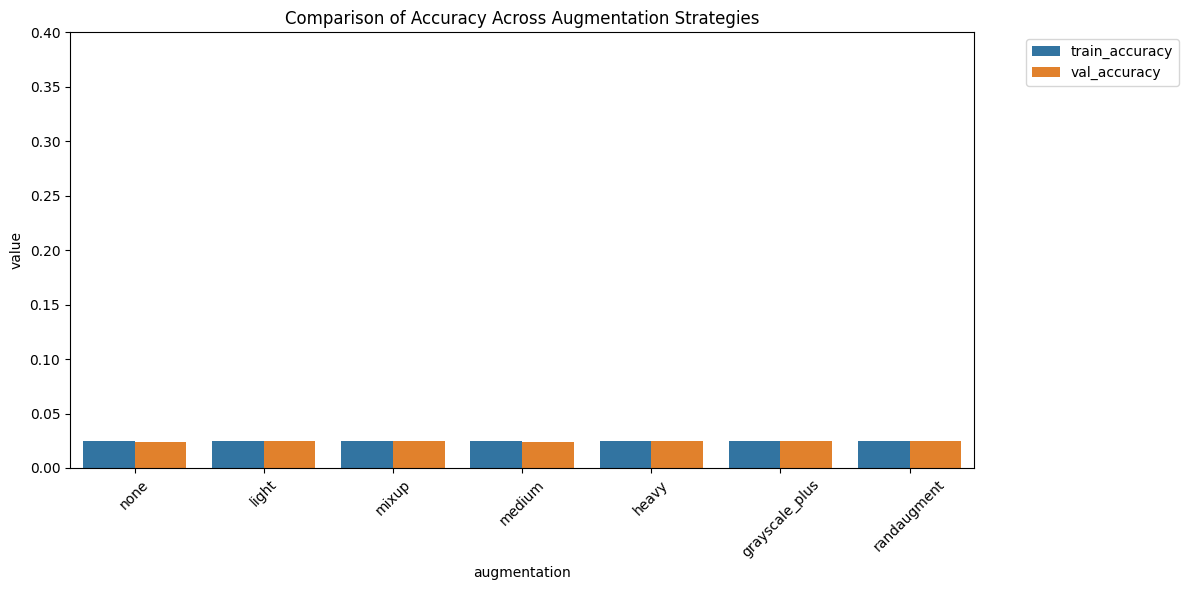

In [25]:
# Melt the DataFrame for seaborn plotting
metrics_to_plot = ['train_accuracy', 'val_accuracy']
melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
plt.title("Comparison of Accuracy Across Augmentation Strategies")
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [26]:
# # Initialize the preprocessor
# batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
# image_size = (224, 224)

# preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     model = build_alexnet()

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#         loss=tf.keras.losses.CategoricalCrossentropy(),
#         metrics=metrics
#     )

#     train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=False, shuffle=True)
#     train_ds_sampled, class_names = preprocess.load_img(data_dir="data/rare_species/train_sampled", minority_class=minority_class, augment=aug, oversampling=False, shuffle=True)
#     val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
#     test_ds, _ = preprocess.load_img(data_dir="data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)


#     # Initialize the experiment
#     experiment = Experiment(
#         model=model,
#         train_ds=train_ds_sampled,
#         val_ds=val_ds,
#         experiment_name=f"alexnet_with_{aug}_no_oversampling", # MUDAR NOME!!!!!!!!!!!!
#         batch_size=32,
#         image_size=(224, 224),
#         resume=False,
#         save_model = False
#     )

#     # Run the experiment
#     history = experiment.run_experiment(callbacks=callbacks, epochs=40)

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")


#     # Clear memory to avoid OOM
#     del model
#     del experiment
#     K.clear_session()
#     gc.collect()


In [27]:
# # Convert results to a DataFrame
# results_df = pd.DataFrame.from_dict(results, orient='index')
# results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# # Display the table
# display(results_df.round(4))

In [28]:
# # Melt the DataFrame for seaborn plotting
# metrics_to_plot = ['accuracy', 'f1_macro', 'f1_weighted', 'precision', 'recall']
# melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
#                             var_name='metric', value_name='value')

# # Plot using seaborn
# plt.figure(figsize=(12, 6))
# sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
# plt.title("Comparison of Metrics Across Augmentation Strategies")
# plt.ylim(0, 0.4)
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()


## AlexNet with oversampling

In [29]:
# Initialize the preprocessor
batch_size = 32
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store results
results = {}

# Loop through each augmentation
for aug in augmentations_to_test:
    print(f"\nTraining with augmentation: {aug}")

    model = build_alexnet()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics
    )

    train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=True, shuffle=True)
    if aug=="grayscale_plus":
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment='grayscale', oversampling=False)
    else:
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)

    # Initialize the experiment
    experiment = Experiment(
        model=model,
        train_ds=train_ds,
        val_ds=val_ds,
        experiment_name=f"alexnet_with_{aug}_oversampling", # MUDAR NOME!!!!!!!!!!!!
        batch_size=32,
        image_size=(224, 224),
        save_model = False
    )

    # Run the experiment
    history = experiment.run_experiment(callbacks=callbacks, epochs=30)

    # Predict entire validation set at once
    preds = model.predict(val_ds)
    y_pred = np.argmax(preds, axis=1)

    # Extract true labels in order
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

    # Compute metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store in results
    train_eval = model.evaluate(train_ds, verbose=0)
    val_eval = model.evaluate(val_ds, verbose=0)

    metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

    train_metrics = dict(zip(metric_names, train_eval))
    val_metrics = dict(zip(metric_names, val_eval))

    # Results
    results[aug] = {
        "train_loss": train_metrics["loss"],
        "val_loss": val_metrics["loss"],

        "train_accuracy": train_metrics["accuracy"],
        "val_accuracy": val_metrics["accuracy"],

        "train_f1_macro": train_metrics.get("f1_macro"),
        "val_f1_macro": val_metrics.get("f1_macro"),

        "val_f1_weighted": val_metrics.get("f1_weighted")
    }


Training with augmentation: none


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 55s 128ms/step - accuracy: 0.0197 - auc: 0.6016 - f1_macro: 0.0011 - f1_weighted: 0.0039 - loss: 5.8542 - top5_accuracy: 0.0917 - val_accuracy: 0.0239 - val_auc: 0.6495 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0751 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.0171 - auc: 0.5989 - f1_macro: 5.3936e-04 - f1_weighted: 0.0021 - loss: 5.1943 - top5_accuracy: 0.0904 - val_accuracy: 0.0239 - val_auc: 0.6500 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0725 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.0190 - auc: 0.6020 - f1_macro: 6.1285e-04 - f1_weighted: 0.0024 - loss: 5.1940 - top5_accuracy: 0.0905 - val_accuracy: 0.0239 - val_a

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: light


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 90s 226ms/step - accuracy: 0.0188 - auc: 0.5967 - f1_macro: 7.6700e-04 - f1_weighted: 0.0030 - loss: 5.5809 - top5_accuracy: 0.0923 - val_accuracy: 0.0250 - val_auc: 0.6486 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0835 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.0172 - auc: 0.5970 - f1_macro: 6.1926e-04 - f1_weighted: 0.0023 - loss: 5.1960 - top5_accuracy: 0.0918 - val_accuracy: 0.0250 - val_auc: 0.6500 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0774 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.0174 - auc: 0.5998 - f1_macro: 4.9406e-04 - f1_weighted: 0.0019 - loss: 5.1917 - top5_accuracy: 0.0966 - val_accuracy: 0.0250 - v

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: mixup


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 55s 130ms/step - accuracy: 0.0198 - auc: 0.5931 - f1_macro: 0.0010 - f1_weighted: 0.0037 - loss: 5.5747 - top5_accuracy: 0.0944 - val_accuracy: 0.0250 - val_auc: 0.6492 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0819 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.0150 - auc: 0.5971 - f1_macro: 5.8468e-04 - f1_weighted: 0.0023 - loss: 5.1987 - top5_accuracy: 0.0913 - val_accuracy: 0.0250 - val_auc: 0.6491 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0811 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.0153 - auc: 0.5999 - f1_macro: 5.7526e-04 - f1_weighted: 0.0022 - loss: 5.1960 - top5_accuracy: 0.0901 - val_accuracy: 0.0250 - val_a

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: medium


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 95s 238ms/step - accuracy: 0.0191 - auc: 0.5986 - f1_macro: 9.0356e-04 - f1_weighted: 0.0032 - loss: 5.6224 - top5_accuracy: 0.0988 - val_accuracy: 0.0239 - val_auc: 0.6501 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0724 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.0184 - auc: 0.5991 - f1_macro: 8.6106e-04 - f1_weighted: 0.0034 - loss: 5.1878 - top5_accuracy: 0.0947 - val_accuracy: 0.0250 - val_auc: 0.6510 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0690 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.0182 - auc: 0.6010 - f1_macro: 7.0046e-04 - f1_weighted: 0.0029 - loss: 5.1859 - top5_accuracy: 0.0950 - val_accuracy: 0.0250 - v

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: heavy


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 99s 247ms/step - accuracy: 0.0196 - auc: 0.6005 - f1_macro: 9.1333e-04 - f1_weighted: 0.0036 - loss: 5.6320 - top5_accuracy: 0.0984 - val_accuracy: 0.0250 - val_auc: 0.6474 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0755 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.0181 - auc: 0.6062 - f1_macro: 5.9423e-04 - f1_weighted: 0.0025 - loss: 5.1797 - top5_accuracy: 0.0983 - val_accuracy: 0.0250 - val_auc: 0.6456 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0744 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.0166 - auc: 0.6076 - f1_macro: 5.4869e-04 - f1_weighted: 0.0023 - loss: 5.1765 - top5_accuracy: 0.1002 - val_accuracy: 0.0250 - v

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: grayscale_plus


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 89s 221ms/step - accuracy: 0.0223 - auc: 0.5956 - f1_macro: 0.0010 - f1_weighted: 0.0040 - loss: 5.7103 - top5_accuracy: 0.0949 - val_accuracy: 0.0250 - val_auc: 0.6509 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0679 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.0223 - auc: 0.5992 - f1_macro: 7.5033e-04 - f1_weighted: 0.0030 - loss: 5.1957 - top5_accuracy: 0.0900 - val_accuracy: 0.0250 - val_auc: 0.6509 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0684 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.0215 - auc: 0.6022 - f1_macro: 5.1596e-04 - f1_weighted: 0.0021 - loss: 5.1908 - top5_accuracy: 0.0923 - val_accuracy: 0.0250 - val_a

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: randaugment


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 179ms/step - accuracy: 0.0188 - auc: 0.6012 - f1_macro: 9.8815e-04 - f1_weighted: 0.0030 - loss: 5.7420 - top5_accuracy: 0.0960 - val_accuracy: 0.0250 - val_auc: 0.6483 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.1026 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.0211 - auc: 0.6033 - f1_macro: 6.5851e-04 - f1_weighted: 0.0027 - loss: 5.1877 - top5_accuracy: 0.0953 - val_accuracy: 0.0250 - val_auc: 0.6493 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0934 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.0184 - auc: 0.6060 - f1_macro: 5.7472e-04 - f1_weighted: 0.0023 - loss: 5.1830 - top5_accuracy: 0.0972 - val_accuracy: 0.0250 - v

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# Display the table
display(results_df.round(4))


,augmentation,train_loss,val_loss,train_accuracy,val_accuracy,train_f1_macro,val_f1_macro,val_f1_weighted
0,none,5.1698,5.0663,0.0203,0.0239,0.0002,0.0002,0.0011
1,light,5.1700,5.0671,0.0204,0.0250,0.0002,0.0002,0.0012
2,mixup,5.1701,5.0735,0.0204,0.0250,0.0002,0.0002,0.0012
3,medium,5.1694,5.0635,0.0199,0.0250,0.0002,0.0002,0.0012
4,heavy,5.1673,5.0717,0.0208,0.0250,0.0002,0.0002,0.0012
5,grayscale_plus,5.1755,5.0679,0.0204,0.0250,0.0002,0.0002,0.0012
6,randaugment,5.1685,5.0764,0.0206,0.0250,0.0002,0.0002,0.0012


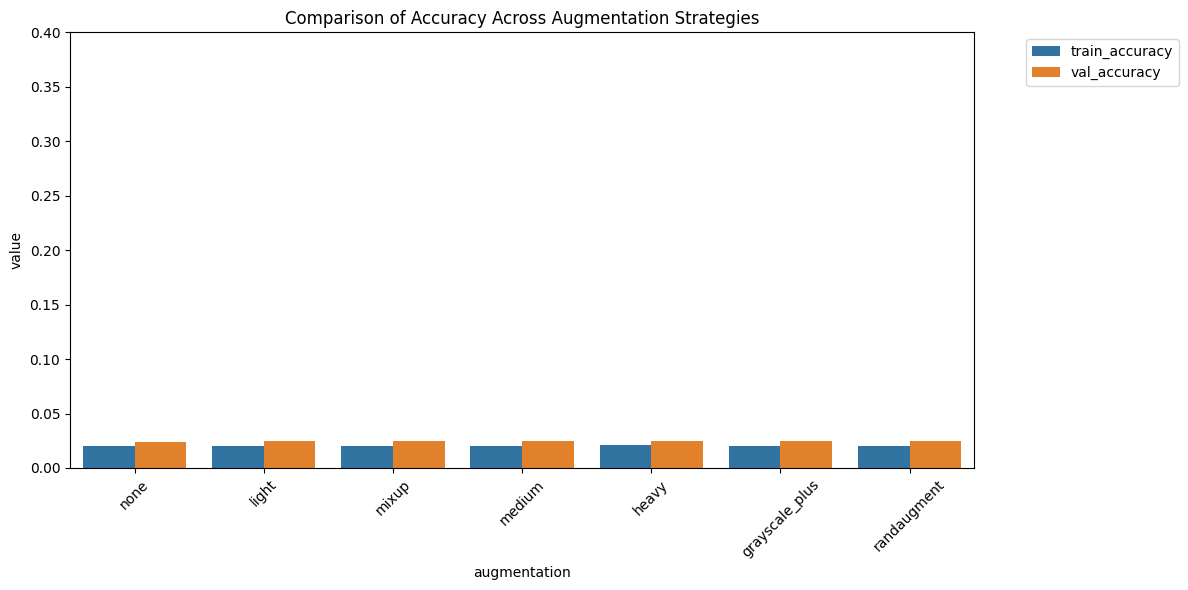

In [31]:
# Melt the DataFrame for seaborn plotting
metrics_to_plot = ['train_accuracy', 'val_accuracy']
melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
plt.title("Comparison of Accuracy Across Augmentation Strategies")
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4.3 ZF net - No oversampling

It’s very similar to AlexNet but with:

Smaller initial filters (7×7 instead of 11×11),
Smaller strides,
Overall more fine-grained feature extraction early on.

In [23]:
def build_zfnet(input_shape=(224, 224, 3), num_classes=202):
    model = Sequential()

    # Conv Layer 1
    model.add(Conv2D(96, (7, 7), strides=2, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Conv Layer 2
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Conv Layer 3
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Conv Layer 4
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Conv Layer 5
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_zfnet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=metrics
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 109, 109, 96)   │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 109, 109, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 54, 54, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 54, 54, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   150,999,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 202)            │       827,594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,335,818 (657.41 MB)

 Trainable params: 172,335,114 (657.41 MB)

 Non-trainable params: 704 (2.75 KB)

In [33]:
# Initialize the preprocessor
batch_size = 32
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store results
results = {}

# Loop through each augmentation
for aug in augmentations_to_test:
    print(f"\nTraining with augmentation: {aug}")

    model = build_zfnet()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics
    )

    train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=False, shuffle=True)
    if aug=="grayscale_plus":
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment='grayscale', oversampling=False)
    else:
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)

    # Initialize the experiment
    experiment = Experiment(
        model=model,
        train_ds=train_ds,
        val_ds=val_ds,
        experiment_name=f"zfnet_with_{aug}_no_oversampling", # MUDAR NOME!!!!!!!!!!!!
        batch_size=32,
        image_size=(224, 224),
        save_model = False
    )

    # Run the experiment
    history = experiment.run_experiment(callbacks=callbacks, epochs=30)

    # Predict entire validation set at once
    preds = model.predict(val_ds)
    y_pred = np.argmax(preds, axis=1)

    # Extract true labels in order
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

    # Compute metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store in results
    train_eval = model.evaluate(train_ds, verbose=0)
    val_eval = model.evaluate(val_ds, verbose=0)

    metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

    train_metrics = dict(zip(metric_names, train_eval))
    val_metrics = dict(zip(metric_names, val_eval))

    # Results
    results[aug] = {
        "train_loss": train_metrics["loss"],
        "val_loss": val_metrics["loss"],

        "train_accuracy": train_metrics["accuracy"],
        "val_accuracy": val_metrics["accuracy"],

        "train_f1_macro": train_metrics.get("f1_macro"),
        "val_f1_macro": val_metrics.get("f1_macro"),

        "val_f1_weighted": val_metrics.get("f1_weighted")
    }


Training with augmentation: none
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-33-0be3b651fde0>", line 40, in <cell line: 0>

  File "/content/drive/MyDrive/FACULDADE/mestrado/classes.py", line 708, in run_experiment

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 2112389904 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_3677140]

In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# Display the table
display(results_df.round(4))


In [ ]:
# Melt the DataFrame for seaborn plotting
metrics_to_plot = ['train_accuracy', 'val_accuracy']
melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
plt.title("Comparison of Accuracy Across Augmentation Strategies")
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# # Initialize the preprocessor
# batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
# image_size = (224, 224)

# preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     model = build_zfnet()

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#         loss=tf.keras.losses.CategoricalCrossentropy(),
#         metrics=metrics
#     )

#     train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=False, shuffle=True)
#     train_ds_sampled, class_names = preprocess.load_img(data_dir="data/rare_species/train_sampled", minority_class=minority_class, augment=aug, oversampling=False, shuffle=True)
#     val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
#     test_ds, _ = preprocess.load_img(data_dir="data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

#     # Initialize the experiment
#     experiment = Experiment(
#         model=model,
#         train_ds=train_ds_sampled,
#         val_ds=val_ds,
#         experiment_name=f"zfnet_with_{aug}_no_oversampling", # MUDAR NOME!!!!!!!!!!!!
#         batch_size=32,
#         image_size=(224, 224),
#         save_model=False
#     )

#     # Run the experiment
#     history = experiment.run_experiment(callbacks=callbacks, epochs=40)

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")

#     # Clear memory to avoid OOM
#     del model
#     del experiment
#     K.clear_session()
#     gc.collect()


In [ ]:
# # Convert results to a DataFrame
# results_df = pd.DataFrame.from_dict(results, orient='index')
# results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# # Display the table
# display(results_df.round(4))


In [ ]:

# # Melt the DataFrame for seaborn plotting
# metrics_to_plot = ['accuracy', 'f1_macro', 'f1_weighted', 'precision', 'recall']
# melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
#                             var_name='metric', value_name='value')

# # Plot using seaborn
# plt.figure(figsize=(12, 6))
# sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
# plt.title("Comparison of Metrics Across Augmentation Strategies")
# plt.ylim(0, 0.4)
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

## ZFNet with oversampling

In [24]:
# Initialize the preprocessor
batch_size = 32
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store results
results = {}

# Loop through each augmentation
for aug in augmentations_to_test:
    print(f"\nTraining with augmentation: {aug}")

    model = build_zfnet()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics
    )

    train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=True, shuffle=True)
    if aug=="grayscale_plus":
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment='grayscale', oversampling=False)
    else:
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)

    # Initialize the experiment
    experiment = Experiment(
        model=model,
        train_ds=train_ds,
        val_ds=val_ds,
        experiment_name=f"zfnet_with_{aug}_oversampling", # MUDAR NOME!!!!!!!!!!!!
        batch_size=32,
        image_size=(224, 224),
        save_model = False
    )

    # Run the experiment
    history = experiment.run_experiment(callbacks=callbacks, epochs=30)

    # Predict entire validation set at once
    preds = model.predict(val_ds)
    y_pred = np.argmax(preds, axis=1)

    # Extract true labels in order
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

    # Compute metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store in results
    train_eval = model.evaluate(train_ds, verbose=0)
    val_eval = model.evaluate(val_ds, verbose=0)

    metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

    train_metrics = dict(zip(metric_names, train_eval))
    val_metrics = dict(zip(metric_names, val_eval))

    # Results
    results[aug] = {
        "train_loss": train_metrics["loss"],
        "val_loss": val_metrics["loss"],

        "train_accuracy": train_metrics["accuracy"],
        "val_accuracy": val_metrics["accuracy"],

        "train_f1_macro": train_metrics.get("f1_macro"),
        "val_f1_macro": val_metrics.get("f1_macro"),

        "val_f1_weighted": val_metrics.get("f1_weighted")
    }


Training with augmentation: none
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 91s 196ms/step - accuracy: 0.0173 - auc: 0.5604 - f1_macro: 7.5039e-04 - f1_weighted: 0.0025 - loss: 9.6009 - top5_accuracy: 0.0769 - val_accuracy: 0.0250 - val_auc: 0.6488 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.7478 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 56s 160ms/step - accuracy: 0.0193 - auc: 0.5958 - f1_macro: 6.9779e-04 - f1_weighted: 0.0028 - loss: 5.7808 - top5_accuracy: 0.0920 - val_accuracy: 0.0250 - val_auc: 0.6499 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.4728 - val_top5_accuracy: 0.1185 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 56s 161ms/step - accuracy: 0.0207 - auc: 0.5986 - f1_macro: 6.9869e-04 - f1_weighted: 0.0028 - loss: 5.5533 - top5_accurac

KeyboardInterrupt: 

In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# Display the table
display(results_df.round(4))


In [ ]:
# Melt the DataFrame for seaborn plotting
metrics_to_plot = ['train_accuracy', 'val_accuracy']
melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
plt.title("Comparison of Accuracy Across Augmentation Strategies")
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4.5 VGGNet - No oversampling

inspired by VGG16 — a deep and uniform architecture with 3x3 convolutions and max pooling.

In [ ]:
def build_vgg_model(input_shape=(224, 224, 3), num_classes=202):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 4 (optional to reduce overfitting)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_vgg_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=metrics
)

model.summary()


In [ ]:
# Initialize the preprocessor
batch_size = 32
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store results
results = {}

# Loop through each augmentation
for aug in augmentations_to_test:
    print(f"\nTraining with augmentation: {aug}")

    model = build_vgg_model()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics
    )

    train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=False, shuffle=True)
    if aug=="grayscale_plus":
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment='grayscale', oversampling=False)
    else:
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)

    # Initialize the experiment
    experiment = Experiment(
        model=model,
        train_ds=train_ds,
        val_ds=val_ds,
        experiment_name=f"vgg_with_{aug}_no_oversampling", # MUDAR NOME!!!!!!!!!!!!
        batch_size=32,
        image_size=(224, 224),
        save_model = False
    )

    # Run the experiment
    history = experiment.run_experiment(callbacks=callbacks, epochs=30)

    # Predict entire validation set at once
    preds = model.predict(val_ds)
    y_pred = np.argmax(preds, axis=1)

    # Extract true labels in order
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

    # Compute metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store in results
    train_eval = model.evaluate(train_ds, verbose=0)
    val_eval = model.evaluate(val_ds, verbose=0)

    metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

    train_metrics = dict(zip(metric_names, train_eval))
    val_metrics = dict(zip(metric_names, val_eval))

    # Results
    results[aug] = {
        "train_loss": train_metrics["loss"],
        "val_loss": val_metrics["loss"],

        "train_accuracy": train_metrics["accuracy"],
        "val_accuracy": val_metrics["accuracy"],

        "train_f1_macro": train_metrics.get("f1_macro"),
        "val_f1_macro": val_metrics.get("f1_macro"),

        "val_f1_weighted": val_metrics.get("f1_weighted")
    }

In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# Display the table
display(results_df.round(4))


In [ ]:
# Melt the DataFrame for seaborn plotting
metrics_to_plot = ['train_accuracy', 'val_accuracy']
melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
plt.title("Comparison of Accuracy Across Augmentation Strategies")
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# # Initialize the preprocessor
# batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
# image_size = (224, 224)

# preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     model = build_vgg_model()

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#         loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
#         metrics=metrics
#     )

#     train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=False, shuffle=True)
#     train_ds_sampled, class_names = preprocess.load_img(data_dir="data/rare_species/train_sampled", minority_class=minority_class, augment=aug, oversampling=False, shuffle=True)
#     val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
#     test_ds, _ = preprocess.load_img(data_dir="data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

#     # Initialize the experiment
#     experiment = Experiment(
#         model=model,
#         train_ds=train_ds_sampled,
#         val_ds=val_ds,
#         experiment_name=f"vggnet_with_{aug}_no_oversampling", # MUDAR NOME!!!!!!!!!!!!
#         batch_size=32,
#         image_size=(224, 224),
#         save_model = False
#     )

#     # Run the experiment
#     history = experiment.run_experiment(callbacks=callbacks, epochs=40)

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")



#     # Clear memory to avoid OOM
#     del model
#     del experiment
#     K.clear_session()
#     gc.collect()


In [ ]:
# # Convert results to a DataFrame
# results_df = pd.DataFrame.from_dict(results, orient='index')
# results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# # Display the table
# display(results_df.round(4))


In [ ]:

# # Melt the DataFrame for seaborn plotting
# metrics_to_plot = ['accuracy', 'f1_macro', 'f1_weighted', 'precision', 'recall']
# melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
#                             var_name='metric', value_name='value')

# # Plot using seaborn
# plt.figure(figsize=(12, 6))
# sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
# plt.title("Comparison of Metrics Across Augmentation Strategies")
# plt.ylim(0, 0.4)
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

## VGGNet2 - With oversampling

In [ ]:
def build_vgg_model(input_shape=(224, 224, 3), num_classes=202):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 4 (optional to reduce overfitting)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_vgg_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=metrics
)

model.summary()


In [ ]:
# Initialize the preprocessor
batch_size = 32
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store results
results = {}

# Loop through each augmentation
for aug in augmentations_to_test:
    print(f"\nTraining with augmentation: {aug}")

    model = build_vgg_model()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics
    )

    train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=True, shuffle=True)
    if aug=="grayscale_plus":
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment='grayscale', oversampling=False)
    else:
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)

    # Initialize the experiment
    experiment = Experiment(
        model=model,
        train_ds=train_ds,
        val_ds=val_ds,
        experiment_name=f"vgg_with_{aug}_oversampling", # MUDAR NOME!!!!!!!!!!!!
        batch_size=32,
        image_size=(224, 224),
        save_model = False
    )

    # Run the experiment
    history = experiment.run_experiment(callbacks=callbacks, epochs=30)

    # Predict entire validation set at once
    preds = model.predict(val_ds)
    y_pred = np.argmax(preds, axis=1)

    # Extract true labels in order
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

    # Compute metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store in results
    train_eval = model.evaluate(train_ds, verbose=0)
    val_eval = model.evaluate(val_ds, verbose=0)

    metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

    train_metrics = dict(zip(metric_names, train_eval))
    val_metrics = dict(zip(metric_names, val_eval))

    # Results
    results[aug] = {
        "train_loss": train_metrics["loss"],
        "val_loss": val_metrics["loss"],

        "train_accuracy": train_metrics["accuracy"],
        "val_accuracy": val_metrics["accuracy"],

        "train_f1_macro": train_metrics.get("f1_macro"),
        "val_f1_macro": val_metrics.get("f1_macro"),

        "val_f1_weighted": val_metrics.get("f1_weighted")
    }

In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# Display the table
display(results_df.round(4))


In [ ]:
# Melt the DataFrame for seaborn plotting
metrics_to_plot = ['train_accuracy', 'val_accuracy']
melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
plt.title("Comparison of Accuracy Across Augmentation Strategies")
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# # Initialize the preprocessor
# batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
# image_size = (224, 224)

# preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     model = build_vgg_model()

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#         loss=tf.keras.losses.CategoricalCrossentropy(),
#         metrics=metrics
#     )

#     train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=True, shuffle=True)
#     train_ds_sampled, class_names = preprocess.load_img(data_dir="data/rare_species/train_sampled", minority_class=minority_class, augment=aug, oversampling=True, shuffle=True)
#     val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
#     test_ds, _ = preprocess.load_img(data_dir="data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

#     # Initialize the experiment
#     experiment = Experiment(
#         model=model,
#         train_ds=train_ds_sampled,
#         val_ds=val_ds,
#         experiment_name=f"vggnet_with_{aug}_oversampling", # MUDAR NOME!!!!!!!!!!!!
#         batch_size=32,
#         image_size=(224, 224),
#         save_model = False
#     )

#     # Run the experiment
#     history = experiment.run_experiment(callbacks=callbacks, epochs=40)

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")


#     # Clear memory to avoid OOM
#     del model
#     del experiment
#     K.clear_session()
#     gc.collect()


In [ ]:
# # Convert results to a DataFrame
# results_df = pd.DataFrame.from_dict(results, orient='index')
# results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# # Display the table
# display(results_df.round(4))

In [ ]:
# # Melt the DataFrame for seaborn plotting
# metrics_to_plot = ['accuracy', 'f1_macro', 'f1_weighted', 'precision', 'recall']
# melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
#                             var_name='metric', value_name='value')

# # Plot using seaborn
# plt.figure(figsize=(12, 6))
# sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
# plt.title("Comparison of Metrics Across Augmentation Strategies")
# plt.ylim(0, 0.4)
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()


## 4.7 DenseNet - No Oversampling

In [ ]:

def dense_layer(x, growth_rate):
    """Single layer inside a dense block."""
    out = BatchNormalization()(x)
    out = ReLU()(out)
    out = Conv2D(growth_rate, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(out)
    x = Concatenate()([x, out])  # Concatenate input and output (dense connection)
    return x

def dense_block(x, num_layers, growth_rate):
    """Dense block with several dense layers."""
    for _ in range(num_layers):
        x = dense_layer(x, growth_rate)
    return x

def transition_layer(x, reduction=0.5):
    """Reduces spatial size and number of filters."""
    filters = int(tf.keras.backend.int_shape(x)[-1] * reduction)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = AveragePooling2D((2, 2), strides=2)(x)
    return x

def build_densenet(input_shape=(224, 224, 3), num_classes=202, growth_rate=32):
    inputs = Input(shape=input_shape)

    # Initial conv
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D((3, 3), strides=2, padding='same')(x)

    # Dense Block 1
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x)

    # Dense Block 2
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x)

    # Dense Block 3
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x)

    # Dense Block 4
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)

    # Classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_densenet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=metrics
)

model.summary()


In [ ]:
# Initialize the preprocessor
batch_size = 32
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store results
results = {}

# Loop through each augmentation
for aug in augmentations_to_test:
    print(f"\nTraining with augmentation: {aug}")

    model = build_densenet()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics
    )

    train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=False, shuffle=True)
    if aug=="grayscale_plus":
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment='grayscale', oversampling=False)
    else:
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)

    # Initialize the experiment
    experiment = Experiment(
        model=model,
        train_ds=train_ds,
        val_ds=val_ds,
        experiment_name=f"densenet_with_{aug}_no_oversampling", # MUDAR NOME!!!!!!!!!!!!
        batch_size=32,
        image_size=(224, 224),
        save_model = False
    )

    # Run the experiment
    history = experiment.run_experiment(callbacks=callbacks, epochs=30)

    # Predict entire validation set at once
    preds = model.predict(val_ds)
    y_pred = np.argmax(preds, axis=1)

    # Extract true labels in order
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

    # Compute metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store in results
    train_eval = model.evaluate(train_ds, verbose=0)
    val_eval = model.evaluate(val_ds, verbose=0)

    metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

    train_metrics = dict(zip(metric_names, train_eval))
    val_metrics = dict(zip(metric_names, val_eval))

    # Results
    results[aug] = {
        "train_loss": train_metrics["loss"],
        "val_loss": val_metrics["loss"],

        "train_accuracy": train_metrics["accuracy"],
        "val_accuracy": val_metrics["accuracy"],

        "train_f1_macro": train_metrics.get("f1_macro"),
        "val_f1_macro": val_metrics.get("f1_macro"),

        "val_f1_weighted": val_metrics.get("f1_weighted")
    }

In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# Display the table
display(results_df.round(4))


In [ ]:
# Melt the DataFrame for seaborn plotting
metrics_to_plot = ['train_accuracy', 'val_accuracy']
melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
plt.title("Comparison of Accuracy Across Augmentation Strategies")
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# # Initialize the preprocessor
# batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
# image_size = (224, 224)

# preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     model = build_densenet()

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#         loss=tf.keras.losses.CategoricalCrossentropy(),
#         metrics=metrics
#     )

#     train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=False, shuffle=True)
#     train_ds_sampled, class_names = preprocess.load_img(data_dir="data/rare_species/train_sampled", minority_class=minority_class, augment=aug, oversampling=False, shuffle=True)
#     val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
#     test_ds, _ = preprocess.load_img(data_dir="data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

#     # Initialize the experiment
#     experiment = Experiment(
#         model=model,
#         train_ds=train_ds_sampled,
#         val_ds=val_ds,
#         experiment_name=f"densenet_with_{aug}_no_oversampling", # MUDAR NOME!!!!!!!!!!!!
#         batch_size=32,
#         image_size=(224, 224),
#         save_model = False
#     )

#     # Run the experiment
#     history = experiment.run_experiment(callbacks=callbacks, epochs=40)

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")

#     # Clear memory to avoid OOM
#     del model
#     del experiment
#     K.clear_session()
#     gc.collect()


In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# Display the table
display(results_df.round(4))


In [ ]:
# Melt the DataFrame for seaborn plotting
metrics_to_plot = ['accuracy', 'f1_macro', 'f1_weighted', 'precision', 'recall']
melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
plt.title("Comparison of Metrics Across Augmentation Strategies")
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## DenseNet 2 - With Oversampling

In [31]:

def dense_layer(x, growth_rate):
    """Single layer inside a dense block."""
    out = BatchNormalization()(x)
    out = ReLU()(out)
    out = Conv2D(growth_rate, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(out)
    x = Concatenate()([x, out])  # Concatenate input and output (dense connection)
    return x

def dense_block(x, num_layers, growth_rate):
    """Dense block with several dense layers."""
    for _ in range(num_layers):
        x = dense_layer(x, growth_rate)
    return x

def transition_layer(x, reduction=0.5):
    """Reduces spatial size and number of filters."""
    filters = int(tf.keras.backend.int_shape(x)[-1] * reduction)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = AveragePooling2D((2, 2), strides=2)(x)
    return x

def build_densenet(input_shape=(224, 224, 3), num_classes=202, growth_rate=32):
    inputs = Input(shape=input_shape)

    # Initial conv
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D((3, 3), strides=2, padding='same')(x)

    # Dense Block 1
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x)

    # Dense Block 2
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x)

    # Dense Block 3
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x)

    # Dense Block 4
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)

    # Classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_densenet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=metrics
)

model.summary()


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ average_pooling2… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 56, 56,    │     18,464 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ average_pooling2… │
│ (Concatenate)       │ 96)               │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 56, 56,    │     27,680 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 56, 56,    │          0 │ concatenate[0][0… │
│ (Concatenate)       │ 128)              │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ concatenate_1[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 56, 56,    │     36,896 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 56, 56,    │          0 │ concatenate_1[0]

 Total params: 817,922 (3.12 MB)

 Trainable params: 811,810 (3.10 MB)

 Non-trainable params: 6,112 (23.88 KB)

In [32]:
# Initialize the preprocessor
batch_size = 32
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store results
results = {}

# Loop through each augmentation
for aug in augmentations_to_test:
    print(f"\nTraining with augmentation: {aug}")

    model = build_densenet()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics
    )

    train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=True, shuffle=True)
    if aug=="grayscale_plus":
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment='grayscale', oversampling=False)
    else:
      val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)

    # Initialize the experiment
    experiment = Experiment(
        model=model,
        train_ds=train_ds,
        val_ds=val_ds,
        experiment_name=f"densenet_with_{aug}_oversampling", # MUDAR NOME!!!!!!!!!!!!
        batch_size=32,
        image_size=(224, 224),
        save_model = False
    )

    # Run the experiment
    history = experiment.run_experiment(callbacks=callbacks, epochs=30)

    # Predict entire validation set at once
    preds = model.predict(val_ds)
    y_pred = np.argmax(preds, axis=1)

    # Extract true labels in order
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

    # Compute metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store in results
    train_eval = model.evaluate(train_ds, verbose=0)
    val_eval = model.evaluate(val_ds, verbose=0)

    metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

    train_metrics = dict(zip(metric_names, train_eval))
    val_metrics = dict(zip(metric_names, val_eval))

    # Results
    results[aug] = {
        "train_loss": train_metrics["loss"],
        "val_loss": val_metrics["loss"],

        "train_accuracy": train_metrics["accuracy"],
        "val_accuracy": val_metrics["accuracy"],

        "train_f1_macro": train_metrics.get("f1_macro"),
        "val_f1_macro": val_metrics.get("f1_macro"),

        "val_f1_weighted": val_metrics.get("f1_weighted")
    }


Training with augmentation: none
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 90s 149ms/step - accuracy: 0.0285 - auc: 0.6050 - f1_macro: 0.0056 - f1_weighted: 0.0120 - loss: 5.4695 - top5_accuracy: 0.0989 - val_accuracy: 0.0373 - val_auc: 0.6489 - val_f1_macro: 0.0054 - val_f1_weighted: 0.0134 - val_loss: 5.2895 - val_top5_accuracy: 0.1252 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.0514 - auc: 0.6916 - f1_macro: 0.0139 - f1_weighted: 0.0271 - loss: 5.0577 - top5_accuracy: 0.1519 - val_accuracy: 0.0540 - val_auc: 0.6826 - val_f1_macro: 0.0138 - val_f1_weighted: 0.0232 - val_loss: 5.0897 - val_top5_accuracy: 0.1692 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0630 - auc: 0.7407 - f1_macro: 0.0238 - f1_weighted: 0.0381 - loss: 4.8120 - top5_accuracy: 0.1977 - val_accura

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: light
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 117s 240ms/step - accuracy: 0.0472 - auc: 0.6434 - f1_macro: 0.0167 - f1_weighted: 0.0295 - loss: 5.4679 - top5_accuracy: 0.1388 - val_accuracy: 0.0273 - val_auc: 0.5945 - val_f1_macro: 0.0030 - val_f1_weighted: 0.0100 - val_loss: 6.5941 - val_top5_accuracy: 0.0935 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.0548 - auc: 0.6959 - f1_macro: 0.0152 - f1_weighted: 0.0290 - loss: 5.0112 - top5_accuracy: 0.1620 - val_accuracy: 0.0390 - val_auc: 0.6536 - val_f1_macro: 0.0065 - val_f1_weighted: 0.0189 - val_loss: 5.6280 - val_top5_accuracy: 0.1224 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.0679 - auc: 0.7398 - f1_macro: 0.0251 - f1_weighted: 0.0400 - loss: 4.8009 - top5_accuracy: 0.1868 - val_accu

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: mixup
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 80s 143ms/step - accuracy: 0.0463 - auc: 0.6109 - f1_macro: 0.0179 - f1_weighted: 0.0277 - loss: 5.5215 - top5_accuracy: 0.1309 - val_accuracy: 0.0334 - val_auc: 0.6054 - val_f1_macro: 0.0025 - val_f1_weighted: 0.0112 - val_loss: 7.5946 - val_top5_accuracy: 0.1096 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0522 - auc: 0.6305 - f1_macro: 0.0074 - f1_weighted: 0.0171 - loss: 5.1687 - top5_accuracy: 0.1496 - val_accuracy: 0.0401 - val_auc: 0.6333 - val_f1_macro: 0.0052 - val_f1_weighted: 0.0187 - val_loss: 7.9011 - val_top5_accuracy: 0.1141 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.0619 - auc: 0.6501 - f1_macro: 0.0120 - f1_weighted: 0.0232 - loss: 5.0524 - top5_accuracy: 0.1682 - val_accur

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: medium
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 123s 254ms/step - accuracy: 0.0640 - auc: 0.6638 - f1_macro: 0.0289 - f1_weighted: 0.0429 - loss: 5.4961 - top5_accuracy: 0.1625 - val_accuracy: 0.0328 - val_auc: 0.6641 - val_f1_macro: 0.0047 - val_f1_weighted: 0.0097 - val_loss: 5.2354 - val_top5_accuracy: 0.1308 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.0493 - auc: 0.6835 - f1_macro: 0.0126 - f1_weighted: 0.0252 - loss: 5.0639 - top5_accuracy: 0.1532 - val_accuracy: 0.0473 - val_auc: 0.6329 - val_f1_macro: 0.0143 - val_f1_weighted: 0.0205 - val_loss: 5.4859 - val_top5_accuracy: 0.1219 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.0630 - auc: 0.7262 - f1_macro: 0.0200 - f1_weighted: 0.0353 - loss: 4.8704 - top5_accuracy: 0.1827 - val_acc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: heavy
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 125s 261ms/step - accuracy: 0.0429 - auc: 0.6366 - f1_macro: 0.0128 - f1_weighted: 0.0238 - loss: 5.5085 - top5_accuracy: 0.1256 - val_accuracy: 0.0362 - val_auc: 0.6229 - val_f1_macro: 0.0048 - val_f1_weighted: 0.0143 - val_loss: 5.4059 - val_top5_accuracy: 0.1119 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0389 - auc: 0.6760 - f1_macro: 0.0083 - f1_weighted: 0.0186 - loss: 5.1063 - top5_accuracy: 0.1398 - val_accuracy: 0.0562 - val_auc: 0.6482 - val_f1_macro: 0.0073 - val_f1_weighted: 0.0213 - val_loss: 5.2119 - val_top5_accuracy: 0.1425 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0517 - auc: 0.7128 - f1_macro: 0.0134 - f1_weighted: 0.0267 - loss: 4.9332 - top5_accuracy: 0.1631 - val_accu

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: grayscale_plus
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 114s 236ms/step - accuracy: 0.0491 - auc: 0.6441 - f1_macro: 0.0203 - f1_weighted: 0.0307 - loss: 5.5267 - top5_accuracy: 0.1399 - val_accuracy: 0.0189 - val_auc: 0.5567 - val_f1_macro: 6.4173e-04 - val_f1_weighted: 0.0022 - val_loss: 5.9653 - val_top5_accuracy: 0.0662 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 68s 76ms/step - accuracy: 0.0426 - auc: 0.6518 - f1_macro: 0.0080 - f1_weighted: 0.0170 - loss: 5.1893 - top5_accuracy: 0.1224 - val_accuracy: 0.0367 - val_auc: 0.6172 - val_f1_macro: 0.0054 - val_f1_weighted: 0.0176 - val_loss: 5.4087 - val_top5_accuracy: 0.1119 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.0483 - auc: 0.6836 - f1_macro: 0.0102 - f1_weighted: 0.0198 - loss: 5.0573 - top5_accuracy: 0.13

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with augmentation: randaugment
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 103s 198ms/step - accuracy: 0.0330 - auc: 0.6105 - f1_macro: 0.0085 - f1_weighted: 0.0174 - loss: 5.5949 - top5_accuracy: 0.1059 - val_accuracy: 0.0301 - val_auc: 0.6310 - val_f1_macro: 0.0023 - val_f1_weighted: 0.0103 - val_loss: 5.2756 - val_top5_accuracy: 0.0952 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0355 - auc: 0.6270 - f1_macro: 0.0056 - f1_weighted: 0.0147 - loss: 5.2869 - top5_accuracy: 0.1111 - val_accuracy: 0.0356 - val_auc: 0.6792 - val_f1_macro: 0.0058 - val_f1_weighted: 0.0146 - val_loss: 5.2697 - val_top5_accuracy: 0.1491 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.0453 - auc: 0.6650 - f1_macro: 0.0084 - f1_weighted: 0.0184 - loss: 5.1408 - top5_accuracy: 0.1302 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# Display the table
display(results_df.round(4))


In [ ]:
# Melt the DataFrame for seaborn plotting
metrics_to_plot = ['train_accuracy', 'val_accuracy']
melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
plt.title("Comparison of Accuracy Across Augmentation Strategies")
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# # Initialize the preprocessor
# batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
# image_size = (224, 224)

# preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     model = build_densenet()

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#         loss=tf.keras.losses.CategoricalCrossentropy(),
#         metrics=metrics
#     )

#     train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=True, shuffle=True)
#     train_ds_sampled, class_names = preprocess.load_img(data_dir="data/rare_species/train_sampled", minority_class=minority_class, augment=aug, oversampling=True, shuffle=True)
#     val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
#     test_ds, _ = preprocess.load_img(data_dir="data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

#     # Initialize the experiment
#     experiment = Experiment(
#         model=model,
#         train_ds=train_ds_sampled,
#         val_ds=val_ds,
#         experiment_name=f"densenet_with_{aug}_oversampling", # MUDAR NOME!!!!!!!!!!!!
#         batch_size=32,
#         image_size=(224, 224),
#         save_model = False
#     )

#     # Run the experiment
#     history = experiment.run_experiment(callbacks=callbacks, epochs=40)

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")

#     # Clear memory to avoid OOM
#     del model
#     del experiment
#     K.clear_session()
#     gc.collect()


In [ ]:
# # Convert results to a DataFrame
# results_df = pd.DataFrame.from_dict(results, orient='index')
# results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# # Display the table
# display(results_df.round(4))


In [ ]:
# # Melt the DataFrame for seaborn plotting
# metrics_to_plot = ['accuracy', 'f1_macro', 'f1_weighted', 'precision', 'recall']
# melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
#                             var_name='metric', value_name='value')

# # Plot using seaborn
# plt.figure(figsize=(12, 6))
# sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
# plt.title("Comparison of Metrics Across Augmentation Strategies")
# plt.ylim(0, 0.4)
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

## DenseNet Grayscale Augmentation - With Oversampling

In [ ]:
# def dense_layer(x, growth_rate):
#     """Single layer inside a dense block."""
#     out = BatchNormalization()(x)
#     out = ReLU()(out)
#     out = Conv2D(growth_rate, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(out)
#     x = Concatenate()([x, out])  # Concatenate input and output (dense connection)
#     return x

# def dense_block(x, num_layers, growth_rate):
#     """Dense block with several dense layers."""
#     for _ in range(num_layers):
#         x = dense_layer(x, growth_rate)
#     return x

# def transition_layer(x, reduction=0.5):
#     """Reduces spatial size and number of filters."""
#     filters = int(tf.keras.backend.int_shape(x)[-1] * reduction)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
#     x = AveragePooling2D((2, 2), strides=2)(x)
#     return x

# def build_densenet(input_shape=(224, 224, 3), num_classes=202, growth_rate=32):
#     inputs = Input(shape=input_shape)

#     # Initial conv
#     x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=l2(1e-4))(inputs)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = AveragePooling2D((3, 3), strides=2, padding='same')(x)

#     # Dense Block 1
#     x = dense_block(x, num_layers=4, growth_rate=growth_rate)
#     x = transition_layer(x)

#     # Dense Block 2
#     x = dense_block(x, num_layers=4, growth_rate=growth_rate)
#     x = transition_layer(x)

#     # Dense Block 3
#     x = dense_block(x, num_layers=4, growth_rate=growth_rate)
#     x = transition_layer(x)

#     # Dense Block 4
#     x = dense_block(x, num_layers=4, growth_rate=growth_rate)

#     # Classification
#     x = GlobalAveragePooling2D()(x)
#     outputs = Dense(num_classes, activation='softmax')(x)

#     return Model(inputs, outputs)

# model = build_densenet()

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     metrics=metrics
# )

# model.summary()


In [ ]:
# # Initialize the preprocessor
# batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
# image_size = (224, 224)

# preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# # Store results
# results = {}

# print(f"\nTraining with augmentation: greysclae")

# model = build_densenet()

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     metrics=metrics
# )

# train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment='grayscale_plus', oversampling=True, shuffle=True)
# train_ds_sampled, class_names = preprocess.load_img(data_dir="data/rare_species/train_sampled", minority_class=minority_class, augment='grayscale_plus', oversampling=True, shuffle=True)
# val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment='grayscale', oversampling=False)
# test_ds, _ = preprocess.load_img(data_dir="data/rare_species/test", minority_class=minority_class, augment='grayscale', oversampling=False)

# # Initialize the experiment
# experiment = Experiment(
#     model=model,
#     train_ds=train_ds_sampled,
#     val_ds=val_ds,
#     experiment_name=f"densenet_with_gray_scale_oversampling_2", # MUDAR NOME!!!!!!!!!!!!
#     batch_size=32,
#     image_size=(224, 224),
#     save_model = False
# )

# # Run the experiment
# history = experiment.run_experiment(callbacks=callbacks, epochs=40)

# # Predict entire validation set at once
# preds = model.predict(val_ds)
# y_pred = np.argmax(preds, axis=1)

# # Extract true labels in order
# y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

# # Compute metrics
# f1_macro = f1_score(y_true, y_pred, average='macro')
# f1_weighted = f1_score(y_true, y_pred, average='weighted')
# precision = precision_score(y_true, y_pred, average='weighted')
# recall = recall_score(y_true, y_pred, average='weighted')

# # Store in results
# results['grayscale'] = {
#     "accuracy": history.history["val_accuracy"][-1],
#     "f1_macro": f1_macro,
#     "f1_weighted": f1_weighted,
#     "precision": precision,
#     "recall": recall
# }

# print(f"Finished '{'grayscale'}'")
# print(f"  Accuracy:      {results['grayscale']['accuracy']:.4f}")
# print(f"  F1 (macro):    {results['grayscale']['f1_macro']:.4f}")
# print(f"  F1 (weighted): {results['grayscale']['f1_weighted']:.4f}")
# print(f"  Precision:     {results['garyscale']['precision']:.4f}")
# print(f"  Recall:        {results['grayscale']['recall']:.4f}")



In [ ]:
# # Store in results
# results['grayscale'] = {
#     "accuracy": history.history["val_accuracy"][-1],
#     "f1_macro": f1_macro,
#     "f1_weighted": f1_weighted,
#     "precision": precision,
#     "recall": recall
# }

# print(f"Finished '{'grayscale'}'")
# print(f"  Accuracy:      {results['grayscale']['accuracy']:.4f}")
# print(f"  F1 (macro):    {results['grayscale']['f1_macro']:.4f}")
# print(f"  F1 (weighted): {results['grayscale']['f1_weighted']:.4f}")
# print(f"  Precision:     {results['grayscale']['precision']:.4f}")
# print(f"  Recall:        {results['grayscale']['recall']:.4f}")

# # Clear memory to avoid OOM
# del model
# del experiment
# K.clear_session()
# gc.collect()

## DenseNet Medium Augmentation - With Oversampling

In [ ]:
# def dense_layer(x, growth_rate):
#     """Single layer inside a dense block."""
#     out = BatchNormalization()(x)
#     out = ReLU()(out)
#     out = Conv2D(growth_rate, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(out)
#     x = Concatenate()([x, out])  # Concatenate input and output (dense connection)
#     return x

# def dense_block(x, num_layers, growth_rate):
#     """Dense block with several -dense layers."""
#     for _ in range(num_layers):
#         x = dense_layer(x, growth_rate)
#     return x

# def transition_layer(x, reduction=0.5):
#     """Reduces spatial size and number of filters."""
#     filters = int(tf.keras.backend.int_shape(x)[-1] * reduction)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
#     x = AveragePooling2D((2, 2), strides=2)(x)
#     return x

# def build_densenet(input_shape=(224, 224, 3), num_classes=202, growth_rate=32):
#     inputs = Input(shape=input_shape)

#     # Initial conv
#     x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=l2(1e-4))(inputs)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = AveragePooling2D((3, 3), strides=2, padding='same')(x)

#     # Dense Block 1
#     x = dense_block(x, num_layers=4, growth_rate=growth_rate)
#     x = transition_layer(x)

#     # Dense Block 2
#     x = dense_block(x, num_layers=4, growth_rate=growth_rate)
#     x = transition_layer(x)

#     # Dense Block 3
#     x = dense_block(x, num_layers=4, growth_rate=growth_rate)
#     x = transition_layer(x)

#     # Dense Block 4
#     x = dense_block(x, num_layers=4, growth_rate=growth_rate)

#     # Classification
#     x = GlobalAveragePooling2D()(x)
#     outputs = Dense(num_classes, activation='softmax')(x)

#     return Model(inputs, outputs)

# model = build_densenet()

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     metrics=metrics
# )

# model.summary()


In [ ]:
# # Initialize the preprocessor
# batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
# image_size = (224, 224)

# preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# # Store results
# results = {}

# print(f"\nTraining with augmentation: medium")

# model = build_densenet()

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     metrics=metrics
# )

# train_ds, class_names = preprocess.load_img(data_dir="data/rare_species/train", minority_class=minority_class, augment='medium', oversampling=True, shuffle=True)
# train_ds_sampled, class_names = preprocess.load_img(data_dir="data/rare_species/train_sampled", minority_class=minority_class, augment='medium', oversampling=True, shuffle=True)
# val_ds, _ = preprocess.load_img(data_dir="data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
# test_ds, _ = preprocess.load_img(data_dir="data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

# # Initialize the experiment
# experiment = Experiment(
#     model=model,
#     train_ds=train_ds_sampled,
#     val_ds=val_ds,
#     experiment_name=f"densenet_with_medium_oversampling_2", # MUDAR NOME!!!!!!!!!!!!
#     batch_size=32,
#     image_size=(224, 224),
#     save_model = False
# )

# # Run the experiment
# history = experiment.run_experiment(callbacks=callbacks, epochs=40)

# # Predict entire validation set at once
# preds = model.predict(val_ds)
# y_pred = np.argmax(preds, axis=1)

# # Extract true labels in order
# y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

# # Compute metrics
# f1_macro = f1_score(y_true, y_pred, average='macro')
# f1_weighted = f1_score(y_true, y_pred, average='weighted')
# precision = precision_score(y_true, y_pred, average='weighted')
# recall = recall_score(y_true, y_pred, average='weighted')

# # Store in results
# results['medium'] = {
#     "accuracy": history.history["val_accuracy"][-1],
#     "f1_macro": f1_macro,
#     "f1_weighted": f1_weighted,
#     "precision": precision,
#     "recall": recall
# }

# print(f"Finished '{'medium'}'")
# print(f"  Accuracy:      {results['medium']['accuracy']:.4f}")
# print(f"  F1 (macro):    {results['medium']['f1_macro']:.4f}")
# print(f"  F1 (weighted): {results['medium']['f1_weighted']:.4f}")
# print(f"  Precision:     {results['medium']['precision']:.4f}")
# print(f"  Recall:        {results['medium']['recall']:.4f}")



In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# Display the table
display(results_df.round(4))

In [ ]:
# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(1, len(acc) + 1)

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()
